# 1-b Graph evolving - Joris

In [1]:
import networkx as nx
import plotly.plotly as py
import plotly.figure_factory as ff
import pandas as pd

Load edge list and create a graph

In [2]:
fh = open("canvas/hamster.edgelist", 'rb')
G = nx.read_edgelist(fh, create_using=nx.DiGraph())
fh.close()

Next we run the pagerank algorithm with a dampening parameter of 0.85. The dampening parameter represents the likelyhood of clicking a link on the webpage. With a dampening parameter of 0.85 we indicate that there is a 85% of clicking a link on the webpage and 15% of going to a random other node in the graph. We calculate the page rank using the power iteration method.

In [3]:
def calc_pagerank(G, alpha = 0.85):
    return nx.pagerank(G, alpha=0.85)

In [4]:
pr_origin = calc_pagerank(G)

In [5]:
def create_dataframe(pr):
    df_edge_in = pd.DataFrame(list(G.in_degree()), columns=['node', 'in edges'])
    df_edge_out = pd.DataFrame(list(G.out_degree()), columns=['node', 'out edges'])
    df_rank = pd.DataFrame(list(pr.items()), columns=['node', 'score']).sort_values(by=['score'], ascending=False)
    df_temp = pd.merge(df_rank, df_edge_in, on='node')
    df_total = pd.merge(df_temp, df_edge_out, on='node')
    df_total.index = df_total.index + 1
    df_total.columns.name = 'rank'
    return df_total

In [6]:
df_origin = create_dataframe(pr_origin)
df_origin.head()

rank,node,score,in edges,out edges
1,404,0.042793,10,0
2,195,0.019961,80,1
3,77,0.018628,121,2
4,728,0.015530,10,0
5,36,0.011117,168,5


It looks like node 404 is the best ranked page, following by 195 and 77. This means that these pages should be shown at the top by search engines.

In [7]:
df_origin.tail()

rank,node,score,in edges,out edges
2422,1746,0.000113,0,3
2423,1748,0.000113,0,4
2424,1749,0.000113,0,3
2425,1751,0.000113,0,2
2426,2426,0.000113,0,8


As expected the higher ranked pages have more incoming edges than the lower ranked pages. Looking at the amount of incoming edges for the 15 best ranked pages it is clear that the the rank of the source of the incoming edges is more important than the amount of incoming edges.

In [8]:
ba = nx.barabasi_albert_graph(10, 2)
dict(nx.all_pairs_shortest_path(ba))

{0: {0: [0],
  1: [0, 2, 1],
  2: [0, 2],
  3: [0, 2, 3],
  4: [0, 2, 1, 4],
  5: [0, 2, 1, 5],
  6: [0, 2, 1, 6],
  7: [0, 2, 3, 7],
  8: [0, 2, 8],
  9: [0, 2, 9]},
 1: {0: [1, 2, 0],
  1: [1],
  2: [1, 2],
  3: [1, 3],
  4: [1, 4],
  5: [1, 5],
  6: [1, 6],
  7: [1, 3, 7],
  8: [1, 8],
  9: [1, 9]},
 2: {0: [2, 0],
  1: [2, 1],
  2: [2],
  3: [2, 3],
  4: [2, 1, 4],
  5: [2, 1, 5],
  6: [2, 1, 6],
  7: [2, 3, 7],
  8: [2, 8],
  9: [2, 9]},
 3: {0: [3, 2, 0],
  1: [3, 1],
  2: [3, 2],
  3: [3],
  4: [3, 4],
  5: [3, 1, 5],
  6: [3, 6],
  7: [3, 7],
  8: [3, 1, 8],
  9: [3, 1, 9]},
 4: {0: [4, 1, 2, 0],
  1: [4, 1],
  2: [4, 1, 2],
  3: [4, 3],
  4: [4],
  5: [4, 5],
  6: [4, 1, 6],
  7: [4, 3, 7],
  8: [4, 1, 8],
  9: [4, 1, 9]},
 5: {0: [5, 1, 2, 0],
  1: [5, 1],
  2: [5, 1, 2],
  3: [5, 1, 3],
  4: [5, 4],
  5: [5],
  6: [5, 1, 6],
  7: [5, 1, 3, 7],
  8: [5, 1, 8],
  9: [5, 1, 9]},
 6: {0: [6, 1, 2, 0],
  1: [6, 1],
  2: [6, 1, 2],
  3: [6, 3],
  4: [6, 1, 4],
  5: [6, 1, 5],
  6:

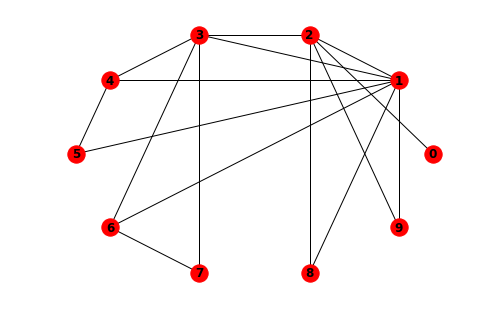

In [9]:
import matplotlib.pyplot as plt
nx.draw_shell(ba, with_labels=True, font_weight='bold')
plt.show()

In [10]:
import networkx as nx
import random
import matplotlib.pyplot as plt

In [11]:
#add new connection to random other node with probability prob_add
#remove random connection of node with probability prob_remove
def randomly_add_edges(G, prob_add, prob_remove):
    add_edges = []
    removed_edges = []
    
    for node in G.nodes():
        #find notes that this one is connected to
        connected = [to for (fr, to) in G.edges(node)]
        #find candidates for new edges
        unconnected = [n for n in G.nodes() if not n in connected]
        
        #randomly add new edge to the selected node
        if len(unconnected): #only add when unconnected is not empty
            if random.random() < prob_add:
                new = random.choice(unconnected)
                G.add_edge(node, new)
                print("\tnew edge:\t {} -- {}".format(node, new))
                add_edges.append( (node, new) )
                #update lists, in case both add and remove done in same cycle
                unconnected.remove(new)    
                connected.append(new)
                
        if len(connected):
            if random.random() < prob_remove:
                remove = random.choice(connected)
                G.remove_edge(node, remove)
                print("\tedge removed:\t {} -- {}".format(node, remove))
                removed_edges.append((node, remove))
                #update lists, in case both add and remove done in same cycle
                connected.remove(remove)
                unconnected.append(remove)
    return G

In [12]:
prob_add = 0.050
prob_remove = 0.005
G_random = randomly_add_edges(G, prob_add, prob_remove)

	new edge:	 29 -- 1270
	new edge:	 116 -- 563
	new edge:	 192 -- 1557
	new edge:	 236 -- 2003
	new edge:	 271 -- 1224
	new edge:	 283 -- 2269
	edge removed:	 285 -- 499
	new edge:	 317 -- 249
	new edge:	 327 -- 413
	new edge:	 339 -- 653
	new edge:	 340 -- 1954
	new edge:	 341 -- 1158
	new edge:	 353 -- 1279
	new edge:	 356 -- 2122
	new edge:	 357 -- 1051
	new edge:	 376 -- 2254
	new edge:	 389 -- 199
	edge removed:	 390 -- 346
	new edge:	 423 -- 1661
	new edge:	 426 -- 1015
	new edge:	 441 -- 2042
	new edge:	 444 -- 2136
	new edge:	 449 -- 957
	new edge:	 455 -- 1182
	new edge:	 456 -- 2211
	new edge:	 473 -- 720
	new edge:	 481 -- 1381
	new edge:	 484 -- 103
	new edge:	 547 -- 1006
	new edge:	 579 -- 65
	new edge:	 606 -- 704
	new edge:	 618 -- 132
	new edge:	 637 -- 928
	new edge:	 663 -- 1706
	new edge:	 679 -- 759
	new edge:	 690 -- 904
	new edge:	 725 -- 1602
	new edge:	 726 -- 513
	new edge:	 728 -- 540
	new edge:	 755 -- 2159
	new edge:	 761 -- 1939
	new edge:	 826 -- 124
	new 

In [13]:
pr_random = calc_pagerank(G_random)
df_random = create_dataframe(pr_random)
df_random.head()

rank,node,score,in edges,out edges
1,404,0.040088,10,0
2,195,0.018667,80,1
3,77,0.017441,121,2
4,433,0.016371,14,0
5,728,0.013703,10,1
